# Introduction

This notebook and the next is meant to give you a taste of neural networks and deep learning. Deep learning is a very large field and the taste will be have to be quite small. The goal is to perhaps satisfy some of your curiosity ("What is deep learning? How do you *do* deep learning") and point you towards ways to learn more about the topic.

In this notebook we'll see how to construct a basic deep neural network in PyTorch, and how to train it to perform a task. 

<img width=60% src="https://miro.medium.com/max/2400/1*aqNgmfyBIStLrf9k7d9cng.jpeg">

## Some good (and short) sources to learn more about artificial neural networks and deep learning

To get a better understanding of what neural networks are and how they work, I recommend watching the following two videos. They provide a nice high-level understanding. 

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/aircAruvnKk" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/IHZwWFHWa-w" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

Here' a way to play around with neural networks directly in the browser: https://playground.tensorflow.org

In [3]:
from IPython.display import IFrame
IFrame('https://playground.tensorflow.org', width=800, height=450)

We'll construct what's called a *convolutional neural network*, the best kind of neural network for images (and more, see the lecture slides for details). 

In [4]:
%%HTML
<video width=60% autoplay loop> <source src="assets/CNN-viz-otavio-good.mp4"> </video>

We won't cover how CNNs work in any detail, but the lecture will give some motivation for why one would want to do CNNs rather than standard fully-connected neural networks. 

For more about how CNNs work, I recommend watching the video below. It gives a nice high-level introduction to convolutional neural networks.

In [5]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/FmpDIaiMIeA" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

# Setup

In [6]:
# Set this to True if you're using Colab:
colab=False

#### For Google Colab

In [7]:
if colab:
    !pip3 install torch torchvision

### Setup libraries and folders

In [8]:
%matplotlib inline

In [9]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import urllib, tarfile, os, shutil

In [10]:
NB_DIR = Path.cwd()

In [11]:
# Change this if you want to store the images that are downloaded
# below elsewhere on your computer.
DATADIR = NB_DIR/'data'

In [12]:
DATADIR.mkdir(exist_ok=True)

In addition to our standard framework imported above, we'll need both torch and torchvision. If you remove the comment symbols (#) from the below cell and run it, pytorch and torchvision will be installed on your computer. Be patient, it may take some time to download the libraries.

In [13]:
#if not colab:
    #import sys
    #!conda install --yes --prefix {sys.prefix} -c pytorch pytorch torchvision

In [14]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

# Load the data

We'll use a simple benchmark data set collected by Dr. Bradley J. Erickson M.D., Ph.D., from the Mayo Clinic, Rochester, USA (and also, by the way, head of the scientific advisory board of [MMIV](https://mmiv.no)), released under the Creative Commons CC BY-SA 4.0 license. 

It consists of 58.954 64x64 images from 6 different classes:

<img src="assets/mednist.png">

The goal is to create a system that can recognize what class an image belongs to. That is, an **image classifier**. 

We can download the data set from Dropbox:

In [15]:
if not os.path.isfile(DATADIR/'MedNIST.tar.gz'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1", DATADIR/'MedNIST.tar.gz')

... then extract it

In [16]:
if not os.path.exists(DATADIR/'MedNIST'):
    shutil.unpack_archive(DATADIR/'MedNIST.tar.gz', extract_dir=DATADIR)

In [17]:
path = DATADIR/'MedNIST'

## Prepare the data

PyTorch (and other deep learning frameworks) operate on what's called **tensors**, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. 

To process the images we need to convert them to such tensors. We also need to create a way to organize the tensors and feed them to models. This can be accomplished by creating what's called a **data loader**.

### Data loaders

In [18]:
# transforms.ToTensor() converts the images to tensors. 
# In addition we make sure the images are grayscale.
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Grayscale(num_output_channels=1)])

In [19]:
dataset = torchvision.datasets.ImageFolder(root=path, 
                                           transform=transform)

In [20]:
len(dataset)

58954

In [21]:
classes = list(dataset.class_to_idx.keys())
classes

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [22]:
trainset, testset = torch.utils.data.random_split(dataset, [41267, 17687], 
                                                  generator=torch.Generator().manual_seed(42))

In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [24]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

### Plot some images

Here are a few images and labels:

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),  cmap='gray')
    plt.show()

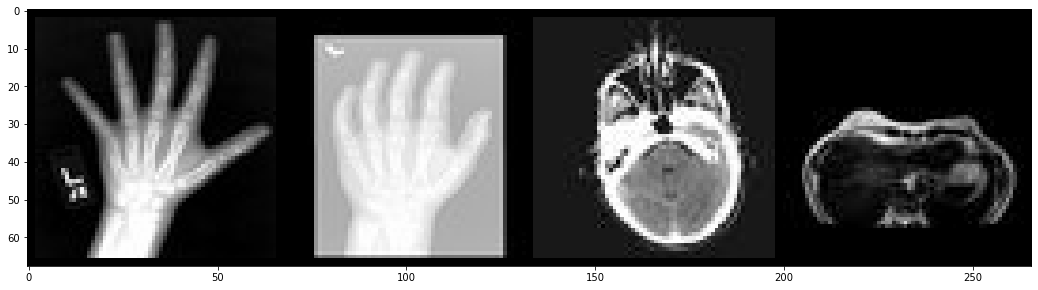

 Hand  Hand HeadCT BreastMRI


In [27]:
# get the next _batch_ of images and labels from the data loader
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show the images
f = plt.figure(figsize=(18,12))
imshow(torchvision.utils.make_grid(images))
# print the corresponding labels
print(f' '.join('%5s' % classes[labels[j]] for j in range(4)))

# A simple neural network

There are two stages to training a neural network: a forward pass to get values for all the nodes between the input and output, and a backward pass where backpropagation (based on what's called _automatic differentiation_ combined with _dynamic programming_) and gradient descent is used to tweak all the parameters in the network. 

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). 

For details about these procedures, see http://cs231n.github.io/optimization-2. 

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass) if we create a network inheriting from `nn.Module`:

## A fully-connected neural net in PyTorch

Here's a simple one hidden layer neural network in PyTorch:

In [28]:
input_size = 64*64*1 # The images are 64x64 grayscale (i.e. single channel images)
hidden_size = 8 # We can choose this number

In [29]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        
        super(Net, self).__init__()
        
        # A hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        
        # An output layer
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)
        
    # We need to define what we want to happen in the forward phase (the backward phase is automatic)
    
    def forward(self, x):
        
        # Make the 64x64 image into a vector
        x = x.view(x.size(0), -1) 
        
        # Feed the input vector through the hidden layer and an activation function
        x = torch.tanh(self.fc1(x)) 
        
        # Output num_classes of numbers.
        # We'll train the network to output a high number for the correct class
        x = self.fc2(x) 
        
        return x

In [30]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = 6)

In [31]:
net

Net(
  (fc1): Linear(in_features=4096, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=6, bias=True)
)

## Training the network

The steps are:
1. Define a neural network (DONE)
2. Collect a batch of training data (we'll use our trainloader)
3. Send these through the network to get its predictions
4. Measure the discrepancy between the true labels and the predictions using a loss function
5. Update all the parameters using backpropagation (to calculate the gradients) and gradient descent (to update the parameters)

### Training the network on a single batch

#### First, lets take a look at a batch

In [32]:
# Get the next batch
i, data = next(enumerate(trainloader, 0))

We've now collected the first batch of 4 images:

In [33]:
images, labels = data

In [34]:
len(images), len(labels)

(4, 4)

The labels of the first four are:

In [35]:
labels

tensor([3, 0, 4, 2])

...which means that the images are of

In [36]:
[classes[label] for label in labels]

['ChestCT', 'AbdomenCT', 'Hand', 'CXR']

The images are torch tensors:

In [37]:
images.shape

torch.Size([4, 1, 64, 64])

Four images (batch size), 1 color channel, images of size 64x64. 

#### Feeding the batch to the network

In [38]:
net

Net(
  (fc1): Linear(in_features=4096, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=6, bias=True)
)

Computing the output of the network from these images is simple:

In [39]:
outputs = net(images)

In [40]:
outputs.shape

torch.Size([4, 6])

As expected, we got four vectors of length 6. Our goal is to make the element in each vector that corresponds to the correct label for the images in the batch as large as possible, while the rest are small. 

Since we haven't trained our network at all yet, we can't expect it to produce any good predictions:

In [41]:
outputs.data

tensor([[ 0.4422,  0.0996, -0.1124, -0.1344,  0.3493, -0.2951],
        [ 0.3912,  0.1653, -0.0776, -0.1395,  0.2831, -0.2895],
        [ 0.2738,  0.1287,  0.0252, -0.0427,  0.3716, -0.3785],
        [ 0.3614,  0.1317, -0.0734, -0.3233,  0.3674, -0.4020]])

In [42]:
_, predicted = torch.max(outputs.data, 1)

In [43]:
predicted

tensor([0, 0, 4, 4])

In [44]:
labels

tensor([3, 0, 4, 2])

In [45]:
[classes[label] for label in predicted]

['AbdomenCT', 'AbdomenCT', 'Hand', 'Hand']

In [46]:
[classes[label] for label in labels]

['ChestCT', 'AbdomenCT', 'Hand', 'CXR']

Chances are none of the predictions are correct. If they are, that's just a coincidence. This is because we've initialized the network with random parameters. 

#### Loss function

To measure the discrepancy between the output and the actual labels, we'll use something called **cross entropy loss**. 

In [47]:
criterion = torch.nn.CrossEntropyLoss()

Let's calculate the loss for our current batch: 

In [48]:
loss = criterion(outputs, labels)

In [49]:
loss

tensor(1.7342, grad_fn=<NllLossBackward>)

#### Backpropagation

Using the `backward` method PyTorch can calculate how much each parameter in the network contributed to the loss by calculating the gradient of the loss with respect to each of them (using a technique called automatic differentation, which is related to the chain rule you know from your maths classes):

In [50]:
loss.backward()

#### Gradient descent

Now we can update all the parameters using stochastic gradient descent:

In [51]:
learning_rate = 0.01

In [52]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Take one step with the optimizer to modify each parameter:

In [53]:
optimizer.step()

The network has now been trained *a tiny bit* (it has learned from the first four images). 

Let's see if that helped:

In [54]:
outputs = net(images)

In [55]:
_, predicted = torch.max(outputs.data, 1)

In [56]:
predicted

tensor([3, 3, 4, 3])

In [57]:
labels

tensor([3, 0, 4, 2])

The network improved (on these four images on which it trained..). 

> **Your turn!** Feed the next batch to the network and check how it performs on those. Not well...

### Going through the training data, batch by batch

The idea now is to repeat this batch by batch, until we've been through the entire training data set multiple times. The idea is that gradient descent will then be able to find good settings for all the parameters, and we can use those when new data is fed through the network. 

Let's first create a simple function for checking the accuracy of the network on the test data:

In [58]:
def check_accuracy(net, dataloader=testloader):
        correct = 0
        total = 0
        
        # Feed all the test data through the net and count the number of correct predictions:
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

        accuracy = correct.numpy() / total
            
        print(f'The accuracy of the network on the test images is: {100 * accuracy}')
        
        return accuracy

Our current accuracy after training on a single batch is

In [59]:
_ = check_accuracy(net)

The accuracy of the network on the test images is: 31.870865607508343


Since the network is essentially untrained this is as expected (randomly guessing among the 6 classes gives an accuracy of 16.7%).

Here's the entire procedure for feeding batches through the network. You can CTRL+ENTER this cell to run it multiple times. You'll see the accuracy improve.

In [60]:
learning_rate = 0.001

In [61]:
# Get next batch
i, data = next(enumerate(trainloader, 0))
images, labels = data
# A technicality: we have to zero out the gradients each time, 
# otherwise they'll accumulate
optimizer.zero_grad()
# Collect the outputs
outputs = net(images)
# Compute the loss
loss = criterion(outputs, labels)
print(f'Current loss: {loss}')
# Compute the gradients of the loss with respect to all the paremeters
loss.backward()
# Update the parameters using gradient descent
optimizer.step()
# Compute the current accuracy
_ = check_accuracy(net)

Current loss: 1.6710222959518433
The accuracy of the network on the test images is: 32.37406004410019


> **Question:** How many times do you have to run the above cell to go through the entire training data set once? 

#### Training loop

We'll go through the entire training set 1 time. Feel free to increase this (but it'll take quite some time as we're running on the CPU, not the GPU [for now]).

In [62]:
num_epochs = 1

In [63]:
%%time
# We record the accuracies during training for later analysis
accuracies = [check_accuracy(net), ]

for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            acc = check_accuracy(net)
            
            print("-"*40)
            accuracies.append(acc)
            running_loss = 0.0

print('Training complete')

The accuracy of the network on the test images is: 32.37406004410019
[1,  1000] loss: 0.618
The accuracy of the network on the test images is: 85.58263131113247
----------------------------------------
[1,  2000] loss: 0.293
The accuracy of the network on the test images is: 93.01181658845479
----------------------------------------
[1,  3000] loss: 0.202
The accuracy of the network on the test images is: 85.08509074461469
----------------------------------------
[1,  4000] loss: 0.153
The accuracy of the network on the test images is: 98.0041838638548
----------------------------------------
[1,  5000] loss: 0.149
The accuracy of the network on the test images is: 97.79499067111438
----------------------------------------
[1,  6000] loss: 0.127
The accuracy of the network on the test images is: 97.95895290326229
----------------------------------------
[1,  7000] loss: 0.105
The accuracy of the network on the test images is: 97.72149036015152
----------------------------------------
[

We can plot the accuracy changes during training:

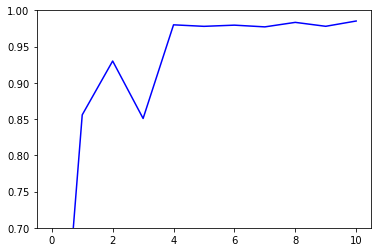

In [64]:
plt.ylim([0.7, 1.0])
plt.plot(accuracies, 'b')
plt.show()

When doing classification, the **confusion matrix** is a very useful tool to evaluate our results.

First we collect lists of the predicted labels for the test data and the true labels:

In [65]:
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(list(predicted.numpy()))
        y_true.append(list(labels.numpy()))        

In [66]:
# Flatten the lists (they are lists of sublists of length batch size)
y_pred = [i for sublist in y_pred for i in sublist]
y_true = [i for sublist in y_true for i in sublist]

...then we compute and plot the confusion matrix as in earlier labs:

In [67]:
from sklearn.metrics import confusion_matrix
from cm_utils import plot_confusion_matrix

In [68]:
cm = confusion_matrix(y_true, y_pred)

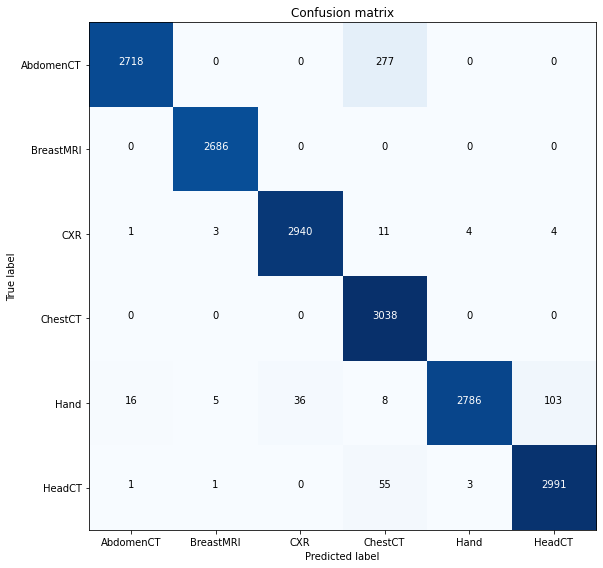

In [69]:
fig, ax = plt.subplots(figsize=(16,8))
_ = plot_confusion_matrix(cm, classes=classes, ax=ax)

**That's it**, basically! Now you know the basics of training neural networks!

However, our above neural network is not particularly powerful. Let's bring in some bigger guns to see what we can achieve.

> **Your turn!** Try adding more neurons to the hidden layer. Also try adding a second hidden layer. How does it influence performance? Try experimenting with the sizes of the hidden layers. Are you able to obtain a better result than above?

> Note: if you remove the "check_accuracy" call in the training loop it'll speed up the training.

# Deep learning

Fundamentally, "deep learning" for neural networks simply means adding more than one hidden layer: i.e. making the network deep. When you did the above "Your turn!" exercise, adding a second hidden layer, you actually _did deep learning_.

However, "deep learning" also refers to an entire field of research, chock-full of exciting ideas, models and techniques. 

It's an extremely hot field that exploded a few years ago and is still growing. See the lecture slides for more background story. 

One of the areas where it has had the most impact is in **computer vision**, for example in **image classification**. In image classification the task is to assign an image to the correct class. If it's an image of a dog, it should be assigned to class "dog". 

That's exactly what we did above, using the MedNIST data set. 

However, our approach was pretty simple compared to what's available from deep learning. The most poweful types of neural networks for image analysis are the so-called **convolutional neural networks**. These are the most famous deep learning models out there. 

# Convolutional neural networks

The lecture gave you some intuition for convolutional neural networks. Let's try to build one.

In [70]:
%%HTML
<video width=60% autoplay loop> <source src="assets/CNN-viz-otavio-good.mp4"> </video>

## A CNN in PyTorch

Here's a very simple CNN:

In [71]:
# Selecting some parameters for the model
kernel_size = 5
out_channels = [10, 20]
fc_features = [320, 50]

In [72]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolution and pooling:
        self.conv1 = torch.nn.Conv2d(in_channels=1, 
                                     out_channels=out_channels[0], 
                                     kernel_size=kernel_size)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels[0], 
                                     out_channels=out_channels[1], 
                                     kernel_size=kernel_size)
        
        
        # Some fully-connected layers at the end:
        self.fc1 = torch.nn.Linear(in_features=3380, 
                                   out_features=fc_features[0])
        
        self.fc2 = torch.nn.Linear(in_features=fc_features[0], 
                                   out_features=fc_features[1])
        
        # Output layer:
        self.fc3 = torch.nn.Linear(in_features=fc_features[1], 
                                   out_features=6)
        
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [73]:
cnn = CNN()

In [74]:
cnn

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3380, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)

In [75]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [76]:
num_epochs = 2

In [77]:
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Training complete')

[1,  1000] loss: 0.623
[1,  2000] loss: 0.171
[1,  3000] loss: 0.081
[1,  4000] loss: 0.069
[1,  5000] loss: 0.070
[1,  6000] loss: 0.042
[1,  7000] loss: 0.031
[1,  8000] loss: 0.030
[1,  9000] loss: 0.022
[1, 10000] loss: 0.023
[2,  1000] loss: 0.030
[2,  2000] loss: 0.027
[2,  3000] loss: 0.017
[2,  4000] loss: 0.011
[2,  5000] loss: 0.033
[2,  6000] loss: 0.027
[2,  7000] loss: 0.013
[2,  8000] loss: 0.011
[2,  9000] loss: 0.021
[2, 10000] loss: 0.008
Training complete


In [78]:
_ = check_accuracy(cnn)

The accuracy of the network on the test images is: 99.54769039407473


Confusion matrix:

In [79]:
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(list(predicted.numpy()))
        y_true.append(list(labels.numpy()))        

y_pred = [i for sublist in y_pred for i in sublist]
y_true = [i for sublist in y_true for i in sublist]

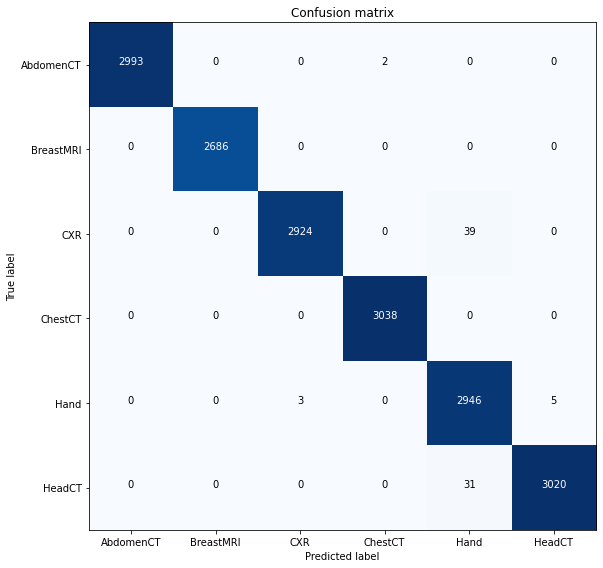

In [80]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(16,8))
_ = plot_confusion_matrix(cm, classes=classes, ax=ax)

> **Your turn!** Try playing with the parameters we chose for our CNN. The kernel_size, the number of output channels (which is the *width* of the network) etc. You can also try adding another convolutional layer to the network to check whether that improves the  result. Note that the training time will increase as you increase the amount of parameters. 

In [81]:
# Number of trainable parameters:
sum(p.numel() for p in cnn.parameters() if p.requires_grad)

1103556

> If you want to make a really big and powerful model, you'll have to use a GPU.. 

### *Next notebook: Taking some steps towards the state-of-the-art in deep learning*